# Twitter Sentiment and Emotion Analysis

**Oihane Cantero, Julen Etxaniz and Jose Javier Saiz**

This corpus is a monolingual resource of unique tweets about product reviews, with each tweet paired with an adversarial sentence. Both original and adversarial tweets are manually and automatically annotated according to sentiment polarity (positive, negative, neutral). The objective is to compare and evaluate both types of annotation.

In [4]:
!pip install transformers

In [158]:
!pip install tweepy --upgrade

     |████████████████████████████████| 66 kB 2.2 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tweepy
    Found existing installation: tweepy 3.10.0
    Uninstalling tweepy-3.10.0:
      Successfully uninstalled tweepy-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Get Tweets

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/MyDrive/LAP/Subjects/BLR/Project/twitter-sentiment

/content/drive/MyDrive/LAP/Subjects/BLR/Project/twitter-sentiment


In [ ]:
import tweepy

with open("auth.txt") as f:
    bearer_token = f.read().split()[2]

client = tweepy.Client(bearer_token=bearer_token)
#Interests and Hobbies Vertical:Technology
query = 'context:65.848920371311001600 lang:en -is:retweet -is:quote -is:reply -has:links'
end_time = '2022-02-01T00:00:00Z'
# tweet_fields = ['context_annotations', 'entities', 'created_at']
tweet_fields = []

tweets = []
for tweet in tweepy.Paginator(client.search_recent_tweets, query=query,
                        tweet_fields=tweet_fields, end_time=end_time, max_results=100).flatten(limit=140):
    tweets.append(tweet)

In [ ]:
import pandas as pd
tweets_df = pd.DataFrame(tweets)
tweets_df

,id,text
0,1488301060334759939,just put a CD into my MacBook to burn it and m...
1,1488301057650438144,oh yeah tesla well what about a car that just ...
2,1488301040160043008,#100DaysOfCode Haven’t updated in a while due ...
3,1488301015514288131,Finally managed to move my business email from...
4,1488301011865419780,why do I have to take a thermodynamics class w...
...,...,...
135,1488299690810503169,Hey! I’d like to introduce a friend.\n\nPlease...
136,1488299665913171975,Day 31 ✅Done\n#100DaysOfCode\n\nFlash Card App...
137,1488299660447940613,i updated my mac and omg its the way it doesn'...
138,1488299656996167683,having no sort of WiFi actually sucks


In [ ]:
tweets_df.to_csv("data/tweets.csv", index_label = "index")

## Inter Annotator Agreement

In [7]:
import pandas as pd
tweets_df = pd.read_csv("data/tweets.csv", usecols=["id", "text"])
tweets_df

,id,text
0,1488301060334759939,just put a CD into my MacBook to burn it and m...
1,1488301057650438144,oh yeah tesla well what about a car that just ...
2,1488301040160043008,#100DaysOfCode Haven’t updated in a while due ...
3,1488301015514288131,Finally managed to move my business email from...
4,1488301011865419780,why do I have to take a thermodynamics class w...
...,...,...
135,1488299690810503169,Hey! I’d like to introduce a friend.\n\nPlease...
136,1488299665913171975,Day 31 ✅Done\n#100DaysOfCode\n\nFlash Card App...
137,1488299660447940613,i updated my mac and omg its the way it doesn'...
138,1488299656996167683,having no sort of WiFi actually sucks


In [8]:
annotators = ["julen", "oihane", "javier"]
tasks = ["sentiment", "emotion"]

### First Annotation

In [9]:
tweets_df_ita = tweets_df[:20]

In [12]:
tweets_df_ita_julen = pd.read_csv("data/twitter_ita_julen.csv")
tweets_df_ita["sentiment_julen"] = tweets_df_ita_julen["sentiment_julen"]
tweets_df_ita["emotion_julen"] = tweets_df_ita_julen["emotion_julen"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
tweets_df_ita_oihane = pd.read_csv("data/twitter_ita_oihane.csv")
tweets_df_ita["sentiment_oihane"] = tweets_df_ita_oihane["sentiment_oihane"]
tweets_df_ita["emotion_oihane"] = tweets_df_ita_oihane["emotion_oihane"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
tweets_df_ita_javier = pd.read_csv("data/twitter_ita_javier.csv")
tweets_df_ita["sentiment_javier"] = tweets_df_ita_javier["sentiment_javier"]
tweets_df_ita["emotion_javier"] = tweets_df_ita_javier["emotion_javier"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
tweets_df_ita

,id,text,sentiment_julen,sentiment_oihane,sentiment_javier,emotion_julen,emotion_oihane,emotion_javier
0,1488301060334759939,just put a CD into my MacBook to burn it and m...,negative,positive,negative,anger,joy,joy
1,1488301057650438144,oh yeah tesla well what about a car that just ...,neutral,positive,negative,joy,joy,anger
2,1488301040160043008,#100DaysOfCode Haven’t updated in a while due ...,negative,negative,negative,sadness,optimism,optimism
3,1488301015514288131,Finally managed to move my business email from...,negative,negative,negative,optimism,optimism,optimism
4,1488301011865419780,why do I have to take a thermodynamics class w...,negative,negative,negative,sadness,anger,anger
5,1488300967443451906,MetroPCS is cutting those on EBB program early...,negative,negative,negative,anger,anger,anger
6,1488300951400243205,You are currently using Linux &lt;3.,positive,positive,neutral,joy,joy,optimism
7,1488300951182012417,All the software I create will be free and ope...,neutral,positive,positive,joy,joy,optimism
8,1488300944353857546,"Ayo, does anyone knows a good game framework l...",neutral,neutral,negative,joy,optimism,optimism
9,1488300940767727620,Just the thought of him running back and forth...,neutral,positive,positive,joy,joy,joy


### Second Annotation

In [16]:
tweets_df_ita_2 = tweets_df[:20]

In [17]:
tweets_df_ita_julen = pd.read_csv("data/twitter_ita_julen.csv")
tweets_df_ita_2["sentiment_julen"] = tweets_df_ita_julen["sentiment_julen"]
tweets_df_ita_2["emotion_julen"] = tweets_df_ita_julen["emotion_julen"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
tweets_df_ita_oihane = pd.read_csv("data/twitter_ita_oihane.csv")
tweets_df_ita_2["sentiment_oihane"] = tweets_df_ita_oihane["sentiment_oihane"]
tweets_df_ita_2["emotion_oihane"] = tweets_df_ita_oihane["emotion_oihane"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
tweets_df_ita_javier = pd.read_csv("data/twitter_ita_javier.csv")
tweets_df_ita_2["sentiment_javier"] = tweets_df_ita_javier["sentiment_javier"]
tweets_df_ita_2["emotion_javier"] = tweets_df_ita_javier["emotion_javier"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
tweets_df_ita_2

,id,text,sentiment_julen,emotion_julen,sentiment_oihane,emotion_oihane,sentiment_javier,emotion_javier
0,1488301060334759939,just put a CD into my MacBook to burn it and m...,negative,anger,positive,joy,negative,joy
1,1488301057650438144,oh yeah tesla well what about a car that just ...,neutral,joy,positive,joy,negative,anger
2,1488301040160043008,#100DaysOfCode Haven’t updated in a while due ...,negative,sadness,negative,optimism,negative,optimism
3,1488301015514288131,Finally managed to move my business email from...,negative,optimism,negative,optimism,negative,optimism
4,1488301011865419780,why do I have to take a thermodynamics class w...,negative,sadness,negative,anger,negative,anger
5,1488300967443451906,MetroPCS is cutting those on EBB program early...,negative,anger,negative,anger,negative,anger
6,1488300951400243205,You are currently using Linux &lt;3.,positive,joy,positive,joy,neutral,optimism
7,1488300951182012417,All the software I create will be free and ope...,neutral,joy,positive,joy,positive,optimism
8,1488300944353857546,"Ayo, does anyone knows a good game framework l...",neutral,joy,neutral,optimism,negative,optimism
9,1488300940767727620,Just the thought of him running back and forth...,neutral,joy,positive,joy,positive,joy


### Calculate Metrics

In [21]:
from nltk.metrics.agreement import AnnotationTask

def get_ita_metrics(tweets_df_ita, task):
    data = []
    for annotator in annotators:
        col = tweets_df_ita[task + "_" + annotator]
        data += [(annotator, str(i), str(val)) for i, val in enumerate(col)]

    task = AnnotationTask(data = data)

    agreement = []
    agreement.append(task.Ao("julen", "oihane"))
    agreement.append(task.Ao("julen", "javier"))
    agreement.append(task.Ao("javier", "oihane"))
    agreement.append(task.avg_Ao())

    kappa = []
    kappa.append(task.kappa_pairwise("julen", "oihane"))
    kappa.append(task.kappa_pairwise("julen", "javier"))
    kappa.append(task.kappa_pairwise("javier", "oihane"))
    kappa.append(task.kappa())

    return agreement, kappa

In [22]:
pairs = ["julen oihane", "julen javier", "javier oihane", "average"]
agreement_sentiment, kappa_sentiment = get_ita_metrics(tweets_df_ita, "sentiment")
agreement_emotion, kappa_emotion = get_ita_metrics(tweets_df_ita, "emotion")

df_ita_results = pd.DataFrame({"pairs": pairs, "agreement_sentiment": agreement_sentiment,
                               "kappa_sentiment": kappa_sentiment, "agreement_emotion": agreement_emotion,
                               "kappa_emotion": kappa_emotion})

df_ita_results

,pairs,agreement_sentiment,kappa_sentiment,agreement_emotion,kappa_emotion
0,julen oihane,0.700000,0.538462,0.550000,0.333333
1,julen javier,0.600000,0.400749,0.400000,0.130435
2,javier oihane,0.600000,0.391635,0.650000,0.461538
3,average,0.633333,0.443615,0.533333,0.308436


In [23]:
pairs = ["julen oihane", "julen javier", "javier oihane", "average"]
agreement_sentiment, kappa_sentiment = get_ita_metrics(tweets_df_ita_2, "sentiment")
agreement_emotion, kappa_emotion = get_ita_metrics(tweets_df_ita_2, "emotion")

df_ita_2_results = pd.DataFrame({"pairs": pairs, "agreement_sentiment": agreement_sentiment,
                               "kappa_sentiment": kappa_sentiment, "agreement_emotion": agreement_emotion,
                               "kappa_emotion": kappa_emotion})

df_ita_2_results

,pairs,agreement_sentiment,kappa_sentiment,agreement_emotion,kappa_emotion
0,julen oihane,0.700000,0.538462,0.550000,0.333333
1,julen javier,0.600000,0.400749,0.400000,0.130435
2,javier oihane,0.600000,0.391635,0.650000,0.461538
3,average,0.633333,0.443615,0.533333,0.308436


## Automatic Analysis

https://arxiv.org/pdf/2010.12421.pdf

https://github.com/cardiffnlp/tweeteval

In [24]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(tweets):
    new_tweets = []
    for text in tweets:
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        new_tweets.append(" ".join(new_text))
    return new_tweets

# Get task parameters (sentiment or emotion)
def get_params(task):
    name = f"cardiffnlp/twitter-roberta-base-{task}"

    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModelForSequenceClassification.from_pretrained(name)

    # download label mapping
    labels=[]
    mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
    with urllib.request.urlopen(mapping_link) as f:
        html = f.read().decode('utf-8').split("\n")
        csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

    return model, tokenizer, labels

# Predict task (sentiment or emotion)
def predict(text, model, tokenizer, labels, task):
    prep_text = preprocess(text)
    text_sents = []
    for text in prep_text:
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        ranking = np.argsort(scores)
        ranking = ranking[::-1]
        sents = {}
        sents[task] = labels[ranking[0]]
        for i in range(scores.shape[0]):
            sents[labels[ranking[i]]] = round(scores[ranking[i]], 3)
        text_sents.append(sents)
    return text_sents

### Sentiment

In [25]:
task = 'sentiment'
model_sentiment, tokenizer_sentiment, labels_sentiment = get_params(task)

In [26]:
sentiment = predict(list(tweets_df["text"]), model_sentiment, tokenizer_sentiment, labels_sentiment, task)

In [27]:
sent = [sent['sentiment'] for sent in sentiment]
negative = [sent['negative'] for sent in sentiment]
neutral = [sent['neutral'] for sent in sentiment]
positive = [sent['positive'] for sent in sentiment]

In [28]:
tweets_df['sentiment_auto'] = sent
tweets_df['negative'] = negative
tweets_df['neutral'] = neutral
tweets_df['positive'] = positive
tweets_df

,id,text,sentiment_auto,negative,neutral,positive
0,1488301060334759939,just put a CD into my MacBook to burn it and m...,positive,0.070,0.398,0.532
1,1488301057650438144,oh yeah tesla well what about a car that just ...,neutral,0.241,0.655,0.104
2,1488301040160043008,#100DaysOfCode Haven’t updated in a while due ...,neutral,0.261,0.500,0.238
3,1488301015514288131,Finally managed to move my business email from...,positive,0.147,0.296,0.557
4,1488301011865419780,why do I have to take a thermodynamics class w...,negative,0.966,0.031,0.002
...,...,...,...,...,...,...
135,1488299690810503169,Hey! I’d like to introduce a friend.\n\nPlease...,positive,0.004,0.214,0.782
136,1488299665913171975,Day 31 ✅Done\n#100DaysOfCode\n\nFlash Card App...,neutral,0.014,0.749,0.237
137,1488299660447940613,i updated my mac and omg its the way it doesn'...,positive,0.002,0.024,0.974
138,1488299656996167683,having no sort of WiFi actually sucks,negative,0.958,0.036,0.006


### Emotion

In [29]:
task = 'emotion'
model_emotion, tokenizer_emotion, labels_emotion = get_params(task)

In [30]:
emotion = predict(list(tweets_df["text"]), model_emotion, tokenizer_emotion, labels_emotion, task)

In [31]:
emot = [emot['emotion'] for emot in emotion]
anger = [emot['anger'] for emot in emotion]
joy = [emot['joy'] for emot in emotion]
optimism = [emot['optimism'] for emot in emotion]
sadness = [emot['sadness'] for emot in emotion]

In [32]:
tweets_df['emotion_auto'] = emot
tweets_df['anger'] = anger
tweets_df['joy'] = joy
tweets_df['optimism'] = optimism
tweets_df['sadness'] = sadness
tweets_df

,id,text,sentiment_auto,negative,neutral,positive,emotion_auto,anger,joy,optimism,sadness
0,1488301060334759939,just put a CD into my MacBook to burn it and m...,positive,0.070,0.398,0.532,joy,0.023,0.921,0.034,0.022
1,1488301057650438144,oh yeah tesla well what about a car that just ...,neutral,0.241,0.655,0.104,joy,0.416,0.450,0.048,0.086
2,1488301040160043008,#100DaysOfCode Haven’t updated in a while due ...,neutral,0.261,0.500,0.238,sadness,0.015,0.216,0.078,0.691
3,1488301015514288131,Finally managed to move my business email from...,positive,0.147,0.296,0.557,optimism,0.048,0.185,0.701,0.066
4,1488301011865419780,why do I have to take a thermodynamics class w...,negative,0.966,0.031,0.002,anger,0.960,0.006,0.007,0.026
...,...,...,...,...,...,...,...,...,...,...,...
135,1488299690810503169,Hey! I’d like to introduce a friend.\n\nPlease...,positive,0.004,0.214,0.782,joy,0.027,0.899,0.059,0.015
136,1488299665913171975,Day 31 ✅Done\n#100DaysOfCode\n\nFlash Card App...,neutral,0.014,0.749,0.237,joy,0.029,0.774,0.159,0.038
137,1488299660447940613,i updated my mac and omg its the way it doesn'...,positive,0.002,0.024,0.974,joy,0.023,0.917,0.040,0.021
138,1488299656996167683,having no sort of WiFi actually sucks,negative,0.958,0.036,0.006,sadness,0.464,0.010,0.006,0.520


## Adversarial Tweets

https://github.com/airbnb/artificial-adversary

In [33]:
!pip install Adversary
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [34]:
tweets_df_adv = pd.read_csv("data/tweets.csv", usecols=["id", "text"])

In [35]:
from Adversary import Adversary
gen = Adversary(verbose=False, output=None)

In [36]:
attacks = ["swap_words", "remove_spacing", "letter_to_symbol", "swap_letters", "insert_punctuation", 
           "insert_duplicate_characters", "delete_characters", "change_case"]

In [37]:
for attack in attacks:
    tweets_adversarial = []
    for i, tweet in tweets_df_adv.iterrows():
        adversarial = gen.generate([tweet.text], attacks=[attack], random_seed=1)[0][0]
        tweets_adversarial.append(adversarial)
    tweets_df_adv["text_" + attack] = tweets_adversarial

In [38]:
tweets_df_adv

,id,text,text_swap_words,text_remove_spacing,text_letter_to_symbol,text_swap_letters,text_insert_punctuation,text_insert_duplicate_characters,text_delete_characters,text_change_case
0,1488301060334759939,just put a CD into my MacBook to burn it and m...,just put a CD into my MacBook to burn and it m...,"just-put`a CD into my MacBook,to burn`it and m...",just put a [D into my MacBook to burn it and m...,just put a CD into my MacBook to burn it and m...,just put a C]{D into my MacBook to ]bu!rn it a...,just put a CDDD into my MacBook to burn it and...,just put a CD into my MacBook to burn it and m...,just put a cd into my MacBook to burn it and m...
1,1488301057650438144,oh yeah tesla well what about a car that just ...,oh yeah tesla well what about a car that logs ...,"oh-yeah`tesla well what about a,car that`just ...",oh yeah tesla well what about a [ar that just ...,oh yeah tesla well what about a car that just ...,oh yeah tesla well what about a c{a]r that jus...,oh yeah tesla well what about a caarr that jus...,oh yeah tesla well what about a car that just ...,oh yeah tesla well what about a cAR that just ...
2,1488301040160043008,#100DaysOfCode Haven’t updated in a while due ...,#100DaysOfCode Haven’t updated in a while due ...,"#100DaysOfCode-Haven’t`updated in a while due,...",#100DaysOfCode Hav{n updated T a while due to ...,#100DaysOfCode Haevn updated in udapted while ...,#100DaysOfCode Hav]{en updated ]!t a while due...,#100DaysOfCode Haveeen updated in uupdaated wh...,#100DaysOfCode Haen updated in a while due whl...,#100DaysOfCode HAVEN updated T a while due to ...
3,1488301015514288131,Finally managed to move my business email from...,Finally managed to move my business email from...,"Finally-managed`to move my business email,from...",Finally managed to mov{ my business ema|| from...,Finally managed to mvoe my business email from...,Finally managed to mov]{e my business ]em!ail ...,Finally managed to moveee my business email fr...,Finally managed to moe my business email from ...,Finally managed to MOVE my busineSs email from...
4,1488301011865419780,why do I have to take a thermodynamics class w...,why do I have to take a thermodynamics class s...,"why-do`I have to take a,thermodynamics class`w...",why do I hav{ to take a therm0dyn@mlCS <Las$ w...,why do I hvae to take a thermodynamics calss w...,why do I hav]{e to take a ]therm!odynamics cla...,why do I haveee to take a thermodynamics cclas...,why do I hae to take a thermodynamics class wh...,why do I HAVE to takE a thermodynamics class w...
...,...,...,...,...,...,...,...,...,...,...
135,1488299690810503169,Hey! I’d like to introduce a friend.\n\nPlease...,Hey! I’d like to introduce a friend. Please sa...,Hey!-I’d`like to introduce a friend.\n\nPlease...,Hey! I’d ’ to introduce a friend. Please say P...,Hey! I’d ’ to introduce a friend. Please say h...,Hey! I’d {]’ to introduce a ]intro!duce Please...,Hey! I’d ’’’ to introduce a friend. Please ffr...,Hey! I’d ’ to introduce a friend. Please say h...,Hey! I’d ’ to introduce a friend. Please FrIEN...
136,1488299665913171975,Day 31 ✅Done\n#100DaysOfCode\n\nFlash Card App...,Day 31 ✅Done #100DaysOfCode Flash App Card Cap...,Day-31`✅Done\n#100DaysOfCode\n\nFlash Card App...,Day 31 ✅Done #100DaysOfCode fLa$h Card App C@p...,Day 31 ✅Done #100DaysOfCode Flash Card App Cpa...,"Day 3]{1 ✅Done ]100Da!ysOfCode Flash C'""ard Ap...",Day 3111 ✅Done #100DaysOfCode FFlassh Card App...,Day 31 ✅Done #100DaysOfCode Flash Card App Cap...,Day 31 ✅Done #100DaysOfCode FlaSh Card App cAP...
137,1488299660447940613,i updated my mac and omg its the way it doesn'...,i updated my mac and omg its the way doesn't i...,"i-updated`my mac and omg its,the way`it doesn'...",i upd@tEd my mac and omg its the way it doesn'...,i upadetd my mac and omg its the way it deos l...,i upd{ate]d my mac and ]om!g its the way it d'...,i updaatedd my mac and omg its the wwaay it do...,i updad my mac and omg its the way it doesn't ...,i updATED my mac and oMg it

### Sentiment

In [39]:
tweets_df_adv_results = pd.read_csv("data/tweets.csv", usecols=["id", "text"])
tweets_df_adv_results

,id,text
0,1488301060334759939,just put a CD into my MacBook to burn it and m...
1,1488301057650438144,oh yeah tesla well what about a car that just ...
2,1488301040160043008,#100DaysOfCode Haven’t updated in a while due ...
3,1488301015514288131,Finally managed to move my business email from...
4,1488301011865419780,why do I have to take a thermodynamics class w...
...,...,...
135,1488299690810503169,Hey! I’d like to introduce a friend.\n\nPlease...
136,1488299665913171975,Day 31 ✅Done\n#100DaysOfCode\n\nFlash Card App...
137,1488299660447940613,i updated my mac and omg its the way it doesn'...
138,1488299656996167683,having no sort of WiFi actually sucks


In [40]:
task = 'sentiment'
for attack in attacks:
    sentiment = predict(list(tweets_df_adv["text_" + attack]), model_sentiment, tokenizer_sentiment, labels_sentiment, task)
    sent = [sent[task] for sent in sentiment]
    tweets_df_adv_results[task + "_" + attack] = sent

In [41]:
tweets_df_adv_results

,id,text,sentiment_swap_words,sentiment_remove_spacing,sentiment_letter_to_symbol,sentiment_swap_letters,sentiment_insert_punctuation,sentiment_insert_duplicate_characters,sentiment_delete_characters,sentiment_change_case
0,1488301060334759939,just put a CD into my MacBook to burn it and m...,positive,positive,positive,positive,positive,neutral,positive,positive
1,1488301057650438144,oh yeah tesla well what about a car that just ...,neutral,neutral,neutral,neutral,neutral,neutral,negative,neutral
2,1488301040160043008,#100DaysOfCode Haven’t updated in a while due ...,neutral,positive,neutral,neutral,positive,neutral,positive,positive
3,1488301015514288131,Finally managed to move my business email from...,positive,positive,positive,positive,positive,positive,positive,positive
4,1488301011865419780,why do I have to take a thermodynamics class w...,negative,negative,negative,negative,negative,negative,negative,negative
...,...,...,...,...,...,...,...,...,...,...
135,1488299690810503169,Hey! I’d like to introduce a friend.\n\nPlease...,positive,neutral,positive,positive,neutral,neutral,neutral,positive
136,1488299665913171975,Day 31 ✅Done\n#100DaysOfCode\n\nFlash Card App...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
137,1488299660447940613,i updated my mac and omg its the way it doesn'...,positive,positive,positive,positive,positive,positive,positive,positive
138,1488299656996167683,having no sort of WiFi actually sucks,negative,negative,neutral,negative,neutral,negative,negative,negative


### Emotion

In [43]:
task = 'emotion'
for attack in attacks:
    emotion = predict(list(tweets_df_adv["text_" + attack]), model_emotion, tokenizer_emotion, labels_emotion, task)
    emot = [emot[task] for emot in emotion]
    tweets_df_adv_results[task + "_" + attack] = emot

In [44]:
tweets_df_adv_results

,id,text,sentiment_swap_words,sentiment_remove_spacing,sentiment_letter_to_symbol,sentiment_swap_letters,sentiment_insert_punctuation,sentiment_insert_duplicate_characters,sentiment_delete_characters,sentiment_change_case,emotion_swap_words,emotion_remove_spacing,emotion_letter_to_symbol,emotion_swap_letters,emotion_insert_punctuation,emotion_insert_duplicate_characters,emotion_delete_characters,emotion_change_case
0,1488301060334759939,just put a CD into my MacBook to burn it and m...,positive,positive,positive,positive,positive,neutral,positive,positive,joy,joy,joy,joy,joy,joy,joy,joy
1,1488301057650438144,oh yeah tesla well what about a car that just ...,neutral,neutral,neutral,neutral,neutral,neutral,negative,neutral,joy,joy,anger,joy,joy,joy,anger,anger
2,1488301040160043008,#100DaysOfCode Haven’t updated in a while due ...,neutral,positive,neutral,neutral,positive,neutral,positive,positive,sadness,sadness,joy,joy,joy,joy,joy,joy
3,1488301015514288131,Finally managed to move my business email from...,positive,positive,positive,positive,positive,positive,positive,positive,optimism,optimism,optimism,optimism,optimism,optimism,optimism,optimism
4,1488301011865419780,why do I have to take a thermodynamics class w...,negative,negative,negative,negative,negative,negative,negative,negative,anger,anger,anger,anger,anger,anger,anger,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,1488299690810503169,Hey! I’d like to introduce a friend.\n\nPlease...,positive,neutral,positive,positive,neutral,neutral,neutral,positive,joy,joy,joy,joy,joy,joy,joy,joy
136,1488299665913171975,Day 31 ✅Done\n#100DaysOfCode\n\nFlash Card App...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,joy,joy,joy,joy,joy,joy,joy,joy
137,1488299660447940613,i updated my mac and omg its the way it doesn'...,positive,positive,positive,positive,positive,positive,positive,positive,joy,joy,joy,sadness,joy,joy,joy,joy
138,1488299656996167683,having no sort of WiFi actually sucks,negative,negative,neutral,negative,neutral,negative,negative,negative,sadness,anger,sadness,anger,sadness,sadness,sadness,anger


## Pie charts

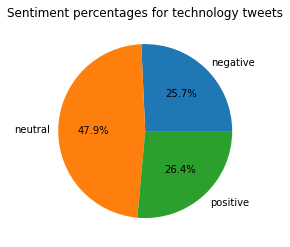

In [45]:
import matplotlib.pyplot as plt
negative_count = sent.count('negative')
neutral_count = sent.count('neutral')
positive_count = sent.count('positive')
plt.pie(x = [negative_count, neutral_count, positive_count], labels=labels_sentiment, autopct='%1.1f%%')
plt.title("Sentiment percentages for technology tweets")
plt.show()

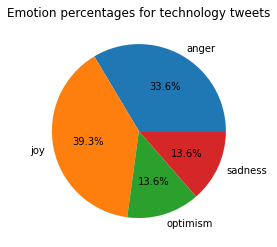

In [46]:
anger_count = emot.count('anger')
joy_count = emot.count('joy')
optimism_count = emot.count('optimism')
sadness_count = emot.count('sadness')
plt.pie(x = [anger_count, joy_count, optimism_count, sadness_count], labels=labels_emotion, autopct='%1.1f%%')
plt.title("Emotion percentages for technology tweets")
plt.show()

## Wordclouds

In [47]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
def create_wordcloud(text):
    wc = WordCloud(max_words=100,
        stopwords=STOPWORDS, width = 1000, height = 1000,
        repeat=True, background_color='white', colormap='Set2')
    wc.generate(str(text))
    plt.figure(figsize=(10, 10))
    plt.imshow(wc)
    plt.axis("off")

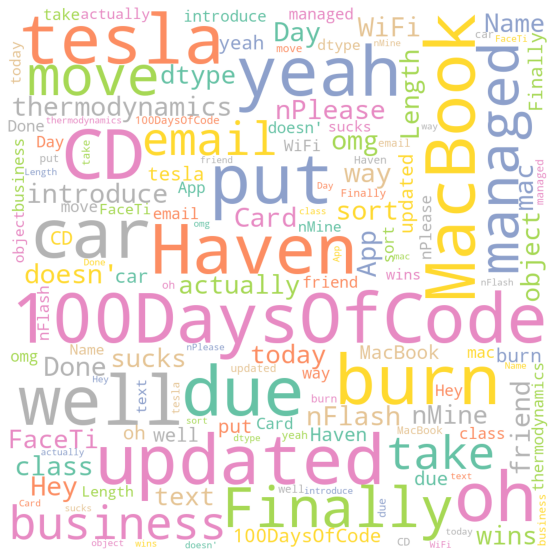

In [48]:
create_wordcloud(tweets_df["text"])

### Manual

#### Sentiment

#### Emotion

### Automatic

#### Sentiment

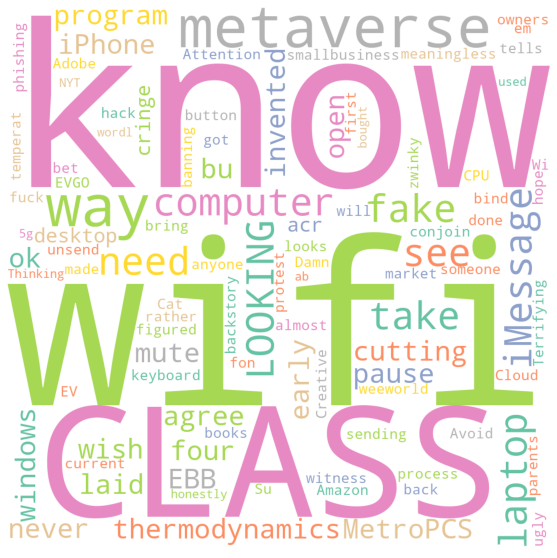

In [49]:
create_wordcloud(tweets_df[tweets_df["sentiment_auto"] == "negative"]["text"])

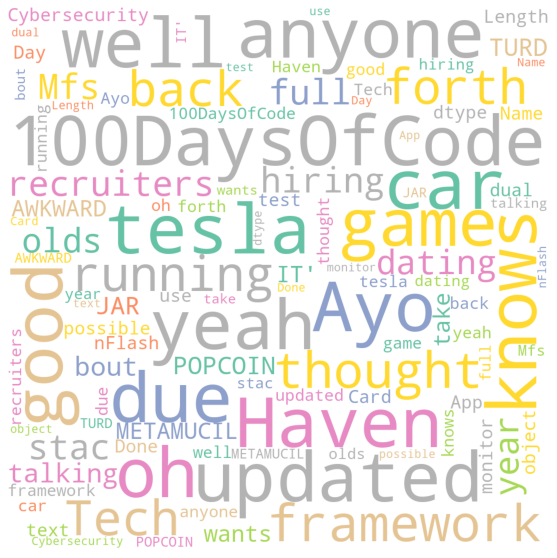

In [50]:
create_wordcloud(tweets_df[tweets_df["sentiment_auto"] == "neutral"]["text"])

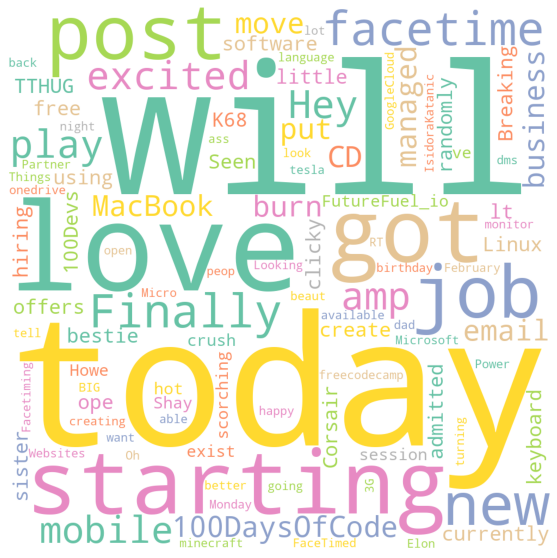

In [51]:
create_wordcloud(tweets_df[tweets_df["sentiment_auto"] == "positive"]["text"])

#### Emotion

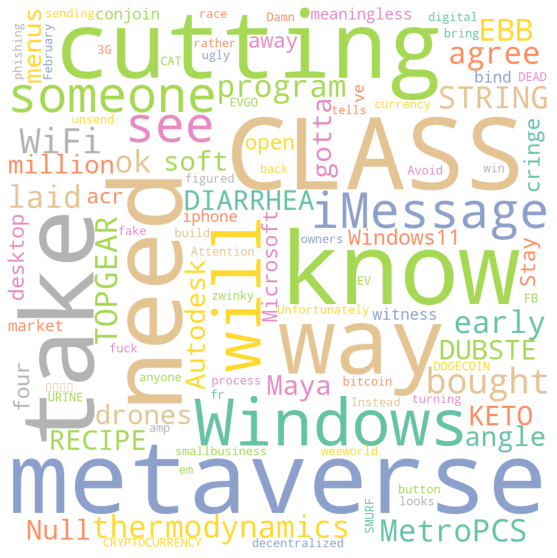

In [52]:
create_wordcloud(tweets_df[tweets_df["emotion_auto"] == "anger"]["text"])

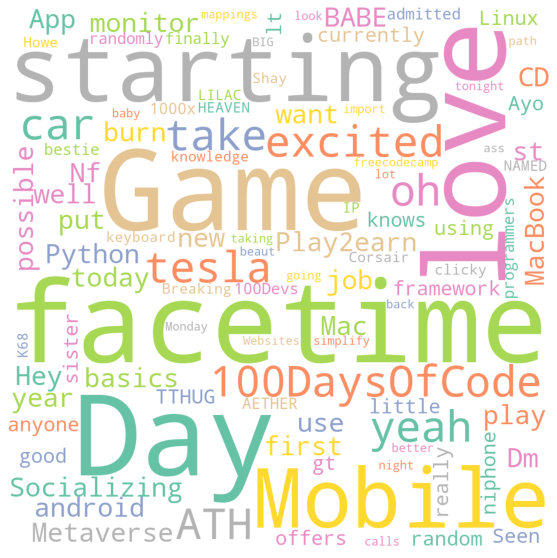

In [53]:
create_wordcloud(tweets_df[tweets_df["emotion_auto"] == "joy"]["text"])

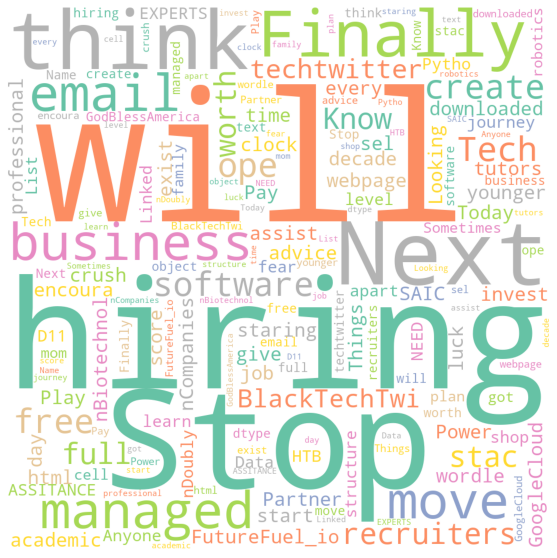

In [54]:
create_wordcloud(tweets_df[tweets_df["emotion_auto"] == "optimism"]["text"])

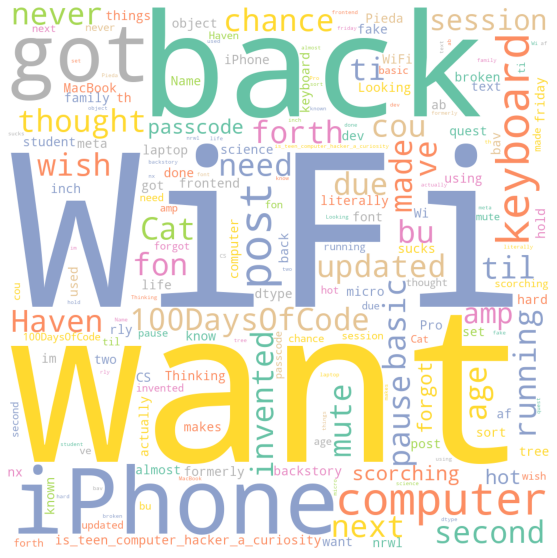

In [55]:
create_wordcloud(tweets_df[tweets_df["emotion_auto"] == "sadness"]["text"])